In [9]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from utils import plot_histo

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from snsynth.mwem import MWEMSynthesizer

# Understanding and using MWEM

MWEM is a simple, practical algorithm for creating differentially private synthetic data. Below we will try to understand how the Smartnoise implementation of MWEM works, how it can be used, and its limitations. We will begin with a visual exploration of what MWEM does to create fake data.

### A Brief Description of MWEM
At its simplest, MWEM works by first creating a uniformly distributed histogram out of real data, and then iteratively updating that histogram with noisy queries drawn from the real data. 

It does this using the **M**ultiplicative **W**eights mechanism, and noisily updates the histograms "weights" with queries drawn via the differentially private **E**xponential **M**echanism .

### Visualizing MWEM
In order to visualize the type of data that MWEM produces, we create a 2D heatmap from histograms drawn from fake data. 

In this way, we can visualize the histogram of the real data distribution, and the histogram for the fake data distribution, which is differentially private. 

Visually, the brighter values correspond to bins with higher counts in each histogram. We adjusted the data here to have a distributional "hot spot" in the bottom right corner.

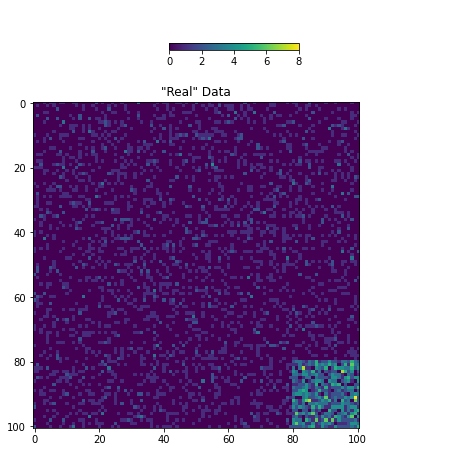

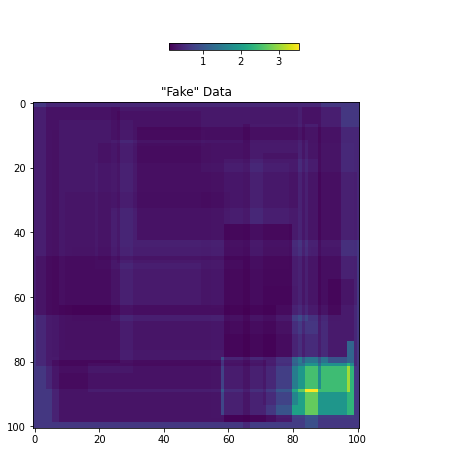

In [10]:
# Make ourselves some fake data, with a "hot-spot" in the distribution
# in the bottom right corner
df = pd.DataFrame({'fake_column_1': [random.randint(0,100) for i in range(3000)] + [random.randint(80,100) for i in range(1000)],
                   'fake_column_2': [random.randint(0,100) for i in range(3000)] + [random.randint(80,100) for i in range(1000)],})

synth = MWEMSynthesizer(epsilon=10.0)
synth.fit(df)

plot_histo('"Real" Data', synth.synthetic_histograms[0][1])
plot_histo('"Fake" Data', synth.synthetic_histograms[0][0])

## Tuning MWEM
MWEM contains a number of tunable parameters that can effect the results of running it on data. Here we will go through each parameter and note its effect on the toy example above.

### Adjusting max_bin_count
MWEM creates an internal picture of the data using a histogram. As with any histogram, the number of "bins" specified per dimension effects the size of the histograms, and the fidelity of the histograms understanding of the data.

Histograms are naturally defined for categorical data, but for ordinal/continuous data we are forced to discretize to a fixed number of buckets. Luckily, MWEM can help us do this. 

MWEM will bin ordinal continuous data between the min/max of a dimension (column). The maximum bins that it will create to this effect is specified with the parameter max_bin_count. In the original data, we have 100 "natural" bins (as we have ordinal data from 0->99). If we set our max bins at 50, MWEM will group the data with less granularity. We can see, however, that we still do a pretty good job at capturing the overall distribution.

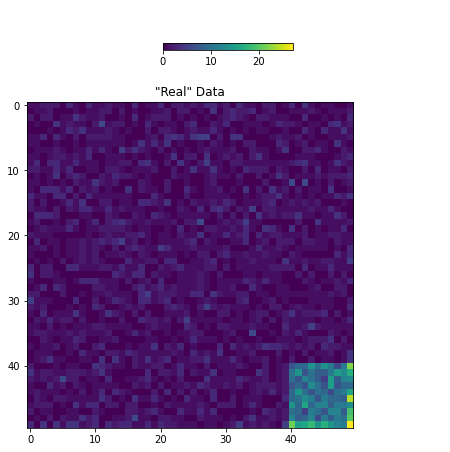

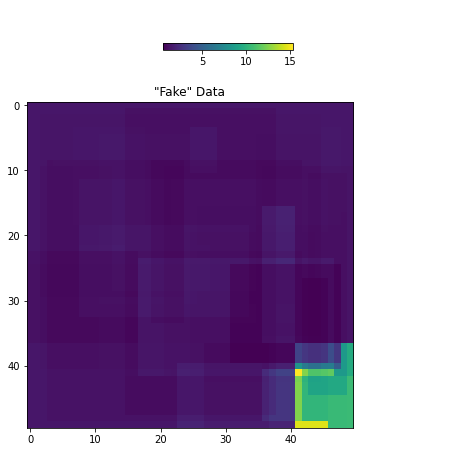

In [11]:
synth = MWEMSynthesizer(epsilon=10.0, max_bin_count=50)
synth.fit(df)

plot_histo('"Real" Data', synth.synthetic_histograms[0][1])
plot_histo('"Fake" Data', synth.synthetic_histograms[0][0])

However, if we adjust our max_bin_count to too great an extreme, we may obfuscate the data distribution entirely. For example, if we set the max bin count here to be 4, we can no longer identify the bottom right corner of our distribution as a "hot spot" with as much certainty.

[[ 737.  778.]
 [ 758. 1727.]]


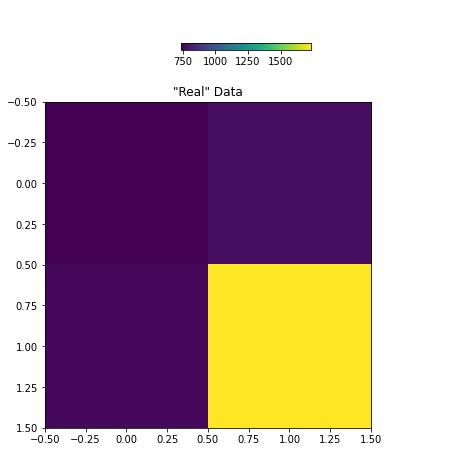

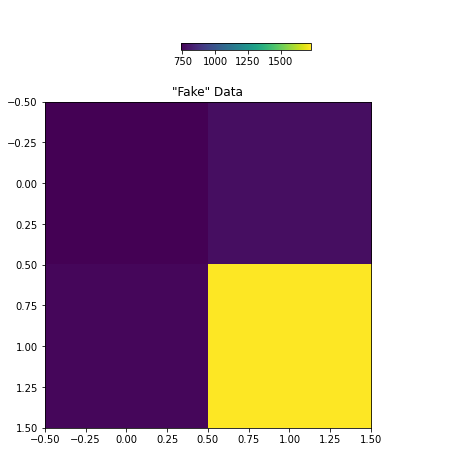

In [32]:
synth = MWEMSynthesizer(epsilon=10.0, max_bin_count=2)
synth.fit(df)

plot_histo('"Real" Data', synth.synthetic_histograms[0][1])
plot_histo('"Fake" Data', synth.synthetic_histograms[0][0])

### Adjusting Splits/Splitfactor
MWEM is in theory severely limited by dimensionality constraints, as the internal histograms grow exponentionally in size with each added column/dimension. The histograms maintain a joint distribution across all the columns if left unchecked.

We address this constraint by allowing for "splits" in our histograms. That is, instead of creating a single private histogram over our entire data distribution, we created *m* private histograms, each of which contains a distribution over d/m dimensions (columns) of the data. Then, when sampling, we draw each of the *m* histograms and knit together their sub-samples to form a sample in the domain of the original data!

This addresses the memory/efficiency issues, but unfortunately has some obvious drawbacks. "Splitting" dimensions from other dimensions does not preserves the marginal distributions between them. Below we give an example of what this looks like with our fake data, where we split our 2d histogram into two one dimensional histograms, and draw from the synthesizer to demonstrate the affect on the synthetic data.

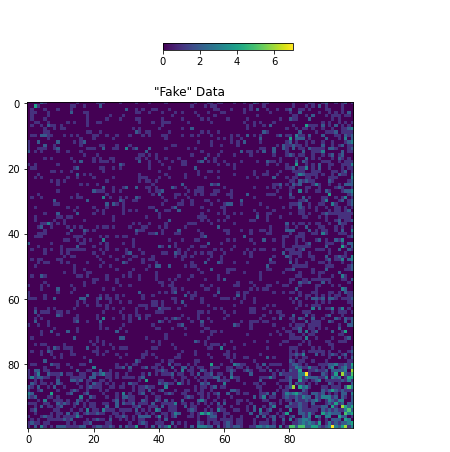

In [35]:
synth = MWEMSynthesizer(epsilon=10.0, splits=[[0],[1]])
synth.fit(df)

samples = synth.sample(4000)
histogram, _, _= np.histogram2d(samples['fake_column_1'],samples['fake_column_2'], bins=100)
plot_histo('"Fake" Data', histogram)

Notice that by splitting the two dimensions, we obfuscate the joint distribution and thus we see false hotpsots in the sample data we create.

Therefore, despite the ability to automatically split features to improve efficiency with split_factor, its important to be careful when splitting your data.